# Proximity Probability and Plume Distance

This notebook explores a framework to assess the probability of observing a climate trace within an ensemble of trajectories, or observing one ensemble given another. The intended applications are to assess :

- how distant/conflicting several reconstructions are from one another
- how (in)compatible model simulations may be compared to a give reconstruction ensemble

Previous attempts using the likelihood (a density of proability) and parametric models have failed to produce robust and numerically sensible results. Here we go back to the drawing board and implement a new method. 

The idea is to give oneself a tube of size $\epsilon$ and shape given by the norm $q$ (circular section for the 2-norm, diamond section for the 1 norm, "Philips head" for the infinity norm). One simply enumerates the number of ensemble trajectories that fit within $\epsilon$ of the target. Given an ensemble $X$ of trajectories, we proceed as follows:
1. compute the $q$-norm distance between a trace $y$ and the `nEns` ensemble members. 
2. graph the distribution of distances $d_q(y,X) = \lVert y-X \rVert_q$ to choose a sensible range of $\epsilon$ parameters
3. Compute the proximity probability $\mathbb{P}(d_q(y,X) \le \epsilon)$ as the proportion of ensemble members that fit within the tube for a given set of $\epsilon$ parameters.
4. Graph this proportion as a function of $\epsilon$. 

We can use this distribution to define simple, robust statistics of distance.

The notebook reproduces Figs 6-9 of the paper. 

In [1]:
%load_ext autoreload
%autoreload 2
import pens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
pens.set_style('journal_nogrid')

## PMIP3 past1000 runs vs LMRonline

First, we focus on assessing these probabilities for the HadCM3 and CCSM4 past1000 GMST traces and their proximity to the LMRonline ensemble:

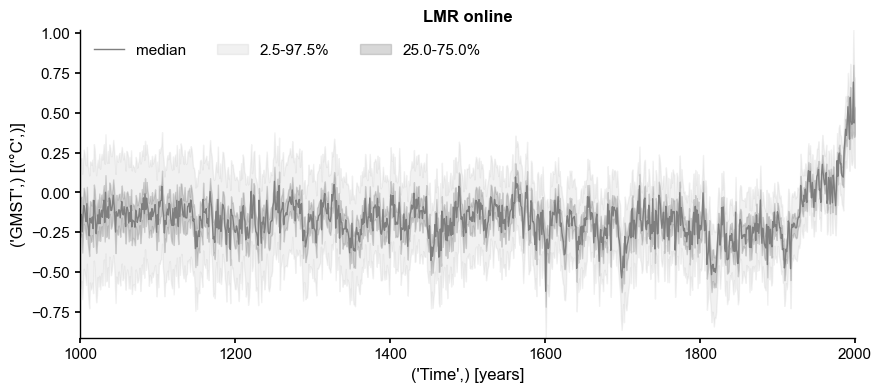

In [2]:
ens_on = pens.EnsembleTS().load_nc('../data/gmt_MCruns_ensemble_full_LMRonline.nc', var='glob_mean', time_name='year')
ens_on.label = 'LMR online'
ens_on.time_unit = 'years'
ens_on.time_name='Time',            # optional metadata: the name of the time axis
ens_on.value_name='GMST',     # optional metadata: the name of the value axis
ens_on.value_unit='\N{DEGREE SIGN}C',      

fig, ax = ens_on.plot_qs(color = 'tab:gray')

In such a representation, it is evident that, as the estimation becomes more uncertain back in time (due to data attrition in this case), the median shows less temporal variability. Conversely, while the ensemble converges around the median after 1500 CE, the median shows more temporal structure. The lack of such structure in the first millennium CE has been commented on (e.g. by Büntgen et al, 2020), with the claim assertion that it "lacks variability", as opposed to  e.g. transient simulations with General Circulation Models (GCMs), like that from HadCM3. 

We first show that such an ensemble is in fact compatible with that simulation, in the sense that one can find an arbitrarily close trajectory within the ensemble that approximates the target. 

## PMIP3 simulations
Let us load and plot the data first:

In [3]:
df = pd.read_table('../data/PMIP3_GMST.txt')
# create a new pandas.DataFrame to store the processed data
dfn = df.copy()

# remove the data columns for CESM and GISS ensemble members
for i in range(10):
    dfn = dfn.drop([f'CESM_member_{i+1}'], axis=1)
    
dfn = dfn.drop(['GISS-E2-R_r1i1p127.1'], axis=1)
dfn = dfn.drop(['GISS-E2-R_r1i1p127'], axis=1)
dfn = dfn.drop(['GISS-E2-R_r1i1p121'], axis=1)

# calculate the ensemble mean for CESM and GISS, and add the results into the table
dfn['CESM'] = df[[
    'CESM_member_1',
    'CESM_member_2',
    'CESM_member_3',
    'CESM_member_4',
    'CESM_member_5',
    'CESM_member_6',
    'CESM_member_7',
    'CESM_member_8',
    'CESM_member_9',
    'CESM_member_10',
]].mean(axis=1)

dfn['GISS'] = df[[
    'GISS-E2-R_r1i1p127.1',   
    'GISS-E2-R_r1i1p127',
    'GISS-E2-R_r1i1p121',
]].mean(axis=1)

# display the processed data
dfn

,Year,bcc_csm1_1,CCSM4,FGOALS_gl,FGOALS_s2,IPSL_CM5A_LR,MPI_ESM_P,CSIRO,HadCM3,CESM,GISS
0,850,-0.570693,-0.431830,NaN,-0.620995,-0.475963,-0.170230,NaN,-0.620517,0.049553,0.127429
1,851,-0.698903,-0.411177,NaN,-0.753160,-0.742970,-0.303124,-0.398695,-0.553043,0.193858,0.138796
2,852,-0.575440,-0.404802,NaN,-0.743508,-0.758939,-0.422623,-0.406343,-0.560791,0.185033,0.098170
3,853,-0.724757,-0.552719,NaN,-0.869331,-0.746460,-0.335177,-0.353557,-0.438949,0.120470,-0.054552
4,854,-0.724328,-0.734938,NaN,-0.826238,-0.684093,-0.650792,-0.416140,-0.812194,-0.081349,-0.407169
...,...,...,...,...,...,...,...,...,...,...,...
1161,2011,1.013544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


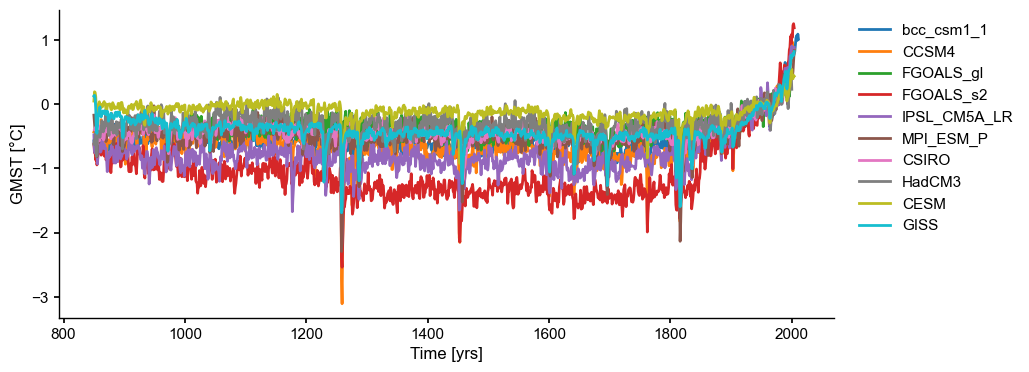

In [4]:
# store each pyleoclim.Series() object into a dictionary and plot
import pyleoclim as pyleo
ts_dict = {}
for name in dfn.columns[1:]:
    ts_dict[name] = pyleo.Series(
        time=dfn['Year'].values,  # the time axis
        value=dfn[name].values,   # the value axis
        label=name,                  # optional metadata: the nickname of the series
        time_name='Time',            # optional metadata: the name of the time axis
        time_unit='yrs',             # optional metadata: the unit of the time axis
        value_name='GMST',     # optional metadata: the name of the value axis
        value_unit='\N{DEGREE SIGN}C',              # optional metadata: the unit of the value axis
        verbose = False,
    )

ts_list = [v for k, v in ts_dict.items()]  # a pythonic way to convert the pyleo.Series items in the dictionary to a list
ms_pmip = pyleo.MultipleSeries(ts_list)
fig, ax = ms_pmip.plot(lgd_kwargs={
        'bbox_to_anchor': (1.25, 1),  # move the legend to the right side
    })

(1000.0, 2000.0)

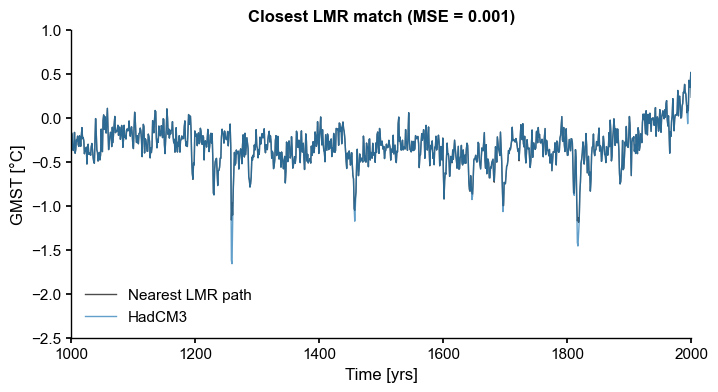

In [5]:
common_time = [1000, 2000]
HadCM3 = ts_list[7].slice(common_time)
CCSM4 = ts_list[1].slice(common_time)
path_nearest = ens_on.sample_nearest(HadCM3.value, metric='MSE')
dist = path_nearest.distance  # extract distance metric
fig, ax = path_nearest.plot(figsize=(8,4),
    title='Closest LMR match (MSE = {:4.3f})'.format(dist),
    color='k', label='Nearest LMR path', alpha=0.7,
)

HadCM3.plot(ax=ax, ylim=(-2.5, 1), alpha=0.7, linewidth=1)
ax.legend(loc='lower left', ncol=1)
ax.set_xlim(common_time)

In [6]:
ts_match = path_nearest.to_pyleo()
corr = ts_match.correlation(HadCM3)
print(corr)

/Users/julieneg/Documents/GitHub/pens/pens/ens.py:429: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a different behavior.
  ts = pyleo.Series(time=self.time, value=self.value[..., i], **kwargs)
/Users/julieneg/Documents/GitHub/pens/pens/ens.py:429: UserWarning: No time_unit parameter provided. Assuming years CE.
  ts = pyleo.Series(time=self.time, value=self.value[..., i], **kwargs)
/Users/julieneg/Documents/GitHub/pens/pens/ens.py:429: UserWarning: No time_name parameter provided. Assuming "Time".
  ts = pyleo.Series(time=self.time, value=self.value[..., i], **kwargs)


Time axis values sorted in ascending order
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.991096  < 1e-6     True



We were indeed able to find a trajectory that highly correlates with the target ($\hat{\rho} > 0.99$). The question is: how *likely* is that trajectory under the ensemble's distribution? How can we define a probability measure over this space, given the number of potential resamplings? For $n=2001$ temporal samples and $m=2000$ ensemble members, this number is $n^m$, which is astronomical. Can a probability still be defined without resorting to brute force? 

## Pathwise Approach : proximity probability

Let's plot the HadCM3 and CCSM4 past1000 GMST traces and vs the density of the LMRonline ensemble:

<Axes: xlabel='Time [yrs]', ylabel='GMST [°C]'>

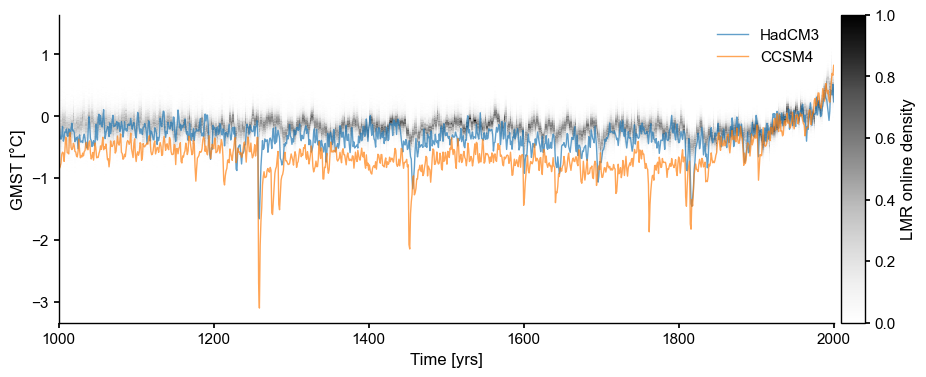

In [7]:
fig, ax = ens_on.line_density()
HadCM3.plot(alpha=0.7, linewidth=1, color='tab:blue',ax=ax)
CCSM4.plot(alpha=0.7, linewidth=1, color='tab:orange',ax=ax)
#pyleo.savefig(fig,path='../figures/HadCM3_CCSM4_LMR_traces.pdf',dpi=300)

Visually, it is evident that HadCM3 is closer to LMRonline than CCSM4. Is this borne out by these metrics? Let us compute the distances between these traces and the ensemble, using different norms:

In [8]:
models = ['HadCM3', 'CCSM4']
order = [1, 2, np.inf]
dist = np.zeros((len(models),len(order),ens_on.nEns))
for m, mdl in enumerate(models):
    for r, ordr in enumerate(order):
        dist[m, r, :] = ens_on.distance(y=eval(mdl).value,order=ordr)

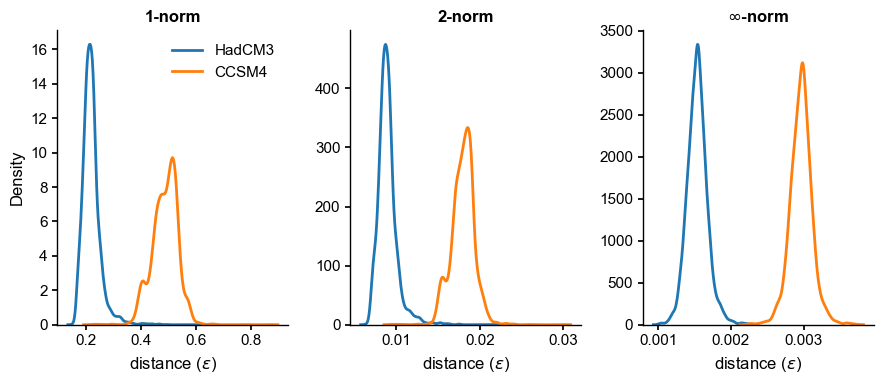

In [9]:
fig, axs = plt.subplots(1,3,figsize=(9,4)) 
axs = axs.flatten()
order_str = ['1','2',r'$\infty$']

for r, ordr in enumerate(order):
    for m, mdl in enumerate(models):
        sns.kdeplot(dist[m, r, :],ax=axs[r],label=mdl)
    axs[r].set_xlabel('distance ($\epsilon$)')
    axs[r].set_title(order_str[r]+'-norm',fontweight='bold')
axs[0].legend()
axs[1].set_ylabel(''); axs[2].set_ylabel('')
fig.tight_layout()
fig.savefig('../figures/HadCM3_CCSM4_LMRonline_distance.pdf',dpi=200)

Indeed, HadCM3 is measurably closer. The results are qualitatively robust to the choice of norm, and surprisingly enough, nearly unchanged from $q=1$ to $q=2$. These results may now guide the choice of $\epsilon$ to compute a probability, e.g. a Cumulative Distribution Function (CDF). For instance with the 1-norm:

Text(0.5, 1.0, 'Proximity probability with respect to LMRonline GMST')

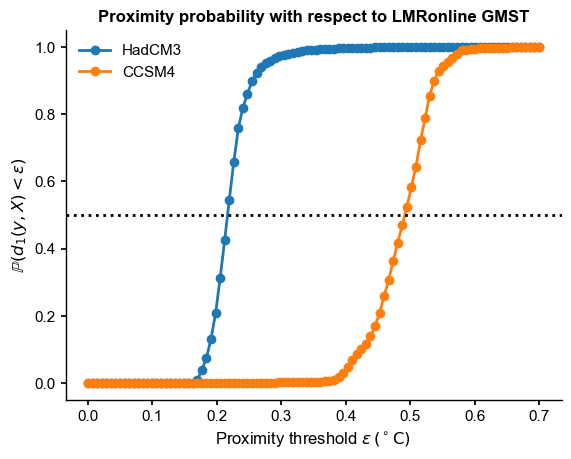

In [10]:
e = np.linspace(0,0.7,num=100)
prob = np.zeros((len(models),len(e)))

fig, ax = plt.subplots()
for m, mdl in enumerate(models):
    prob[m, :] = ens_on.proximity_prob(y=eval(mdl).value, eps=e, order=1)
    ax.plot(e,prob[m, :],label=mdl,marker='o')  
ax.legend()
ax.axhline(y=0.5,color='k',ls=':')
ax.set_xlabel(r'Proximity threshold $\epsilon \, ({}^\circ \mathrm{C})$ ')
ax.set_ylabel(r'$\mathbb{P}(d_1(y,X) < \epsilon)$') 
ax.set_title("Proximity probability with respect to LMRonline GMST", fontweight = 'bold')

(results are nearly indistinguishable with the 2-norm). 

## Plume distance
### Definition

From the CDFs obtained above, we would like to extract one metric that best summarizes the differences. In our tests, the shapes are very similar (abrupt climb for intermediate values of the proximity threshold), so a simple approach is to pick the difference between the values of epsilon for which these CDFs intersect $P = 0.5$:

In [11]:
# use this strategy for root finding: https://stackoverflow.com/a/46911822
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

In [12]:
eps_med = np.zeros((len(models)))
for m in range(2):
    eps_med[m] = find_roots(e, prob[m, :]-0.5)[0]
print(eps_med[1] - eps_med[0]) 

0.2752498938114215


This metric suggests that HadCM3 is closer to LMRonline by about 0.27 degrees. ($\epsilon$ has the same units as the variable of interest, in this case GMST). This is implemented as `plume_distance()` in `pens`:

In [13]:
dist_HadCM3 = ens_on.plume_distance(y=eval('HadCM3').value, max_dist=0.7)
dist_CCSM4 = ens_on.plume_distance(y=eval('CCSM4').value, max_dist=0.7)    
delta_eps =  dist_CCSM4 -  dist_HadCM3  
print(f'$\Delta_\epsilon = {delta_eps}$')

$\Delta_\epsilon = 0.2752498938114215$


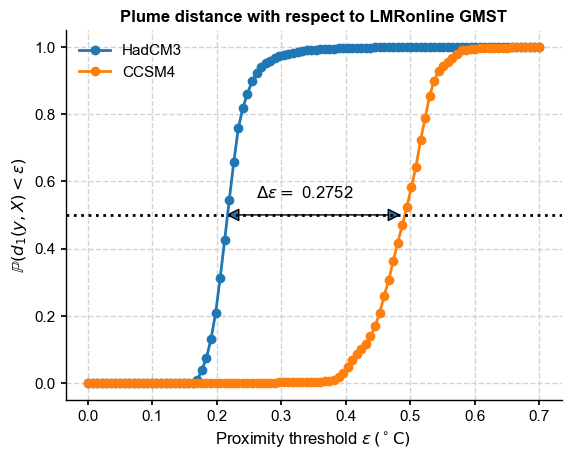

In [14]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
yr = 0.55; xr = 0.35
for m, mdl in enumerate(models):
    prob[m, :] = ens_on.proximity_prob(y=eval(mdl).value, eps=e, order=1)
    ax.plot(e,prob[m, :],label=mdl,marker='o')  
ax.legend()
ax.axhline(y=0.5,color='k',ls=':')
ax.text(x=xr-.09, y=yr,s=fr'$\Delta \epsilon = $ {delta_eps:.4f}')
pa = patches.FancyArrowPatch((0.21, .5), (0.49, .5), arrowstyle='<|-|>', mutation_scale=20)
ax.add_patch(pa)
ax.set_xlabel(r'Proximity threshold $\epsilon \, ({}^\circ \mathrm{C})$ ')
ax.set_ylabel(r'$\mathbb{P}(d_1(y,X) < \epsilon)$') 
ax.set_title("Plume distance with respect to LMRonline GMST", fontweight = 'bold')
fig.savefig('../figures/HadCM3_CCSM4_LMRonline_plume_CDF.pdf',dpi=200)

There would be many other possible metrics: 
- maximum horizontal difference between the 2 curves (similar to the Kolmogorov-Smyrnov statistic for CDFs)
- area between the two curves (harder to compute, and units are less intuitive). 

In [15]:
imax = np.abs(np.diff(prob,axis=0)).argmax()
print(f'Max distance = {e[imax]}, prob = {prob[1,imax]}')

Max distance = 0.3606060606060606, prob = 0.004


This maximum distance falls at an extremely low probability, which seems arbitrary. The median seems a more justifiable choice, and a very easy one to implement. What are the properties of this newly defined metric?

### Mathematical Properties of the Plume Distance

Let us show that this verifies the conditions of a usual distance:
- _The distance from an object to itself is zero_: it is trivially the case that if all the individual distances are 0, the distribution is a delta function centered at 0. 

In [16]:
ens1 = ens_on.subsample(400) # subsample for computational convenience
ens2 = ens_on.subsample(400)
d00 = ens1.plume_distance(y=ens1, max_dist=1)
print(d00)

objects are numerically identical
0


More interesting is the case where thin subsets of the same ensemble are compared: the distance between two subsamples of the same plume will be small, but finite:

In [17]:
ens1.plume_distance(y=ens2, max_dist=1)

0.07140369209334728

It tends to decrease as the ensemble size gets larger (better sampling of the full distribution): 

In [18]:
ens1 = ens_on.subsample(2000) # subsample for computational convenience
ens2 = ens_on.subsample(2000)
ens1.plume_distance(y=ens2, max_dist=1)

0.05365622032288699

- (Positivity) _The distance between two distinct points is always positive_:
trivial, as the metric can only pick $\epsilon$ values that are positive-definite.

- (Symmetry) _The distance from x to y is always the same as the distance from y to x_

Let's compute this two ways and compare the result:

In [19]:
ens1 = ens_on.subsample(400) # subsample for computational convenience
ens2 = ens_on.subsample(400)
d21 = ens1.plume_distance(y=ens2, max_dist=1)
d12 = ens2.plume_distance(y=ens1, max_dist=1)
print(d21-d12)

0.0


-  The triangle inequality holds $d(x, z) \leq d(x, y) + d(y, z)$

@Frederi: can you think of an easy way to prove this? 

## Plume-to-plume distance


### LMRoffline vs LMRonline
Let's see how compatible LMRonline and LMRv2.1 (offline) are by this metric:

In [14]:
path = '../data/gmt_MCruns_ensemble_full_LMRv2.1.nc'
LMR = pens.EnsembleTS().load_nc(path, var='gmt')
ens_off  = LMR.slice(common_time)
ens_off.label = 'LMR v2.1'
ens_off.value_name = 'GMST'
ens_off.value_unit = '\N{DEGREE SIGN}C'

In [15]:
ens_o2000 = ens_on.subsample(nsamples=ens_off.nEns)
LMR_on_off_plume_dist = ens_o2000.plume_distance(ens_off,max_dist=0.7)
print(LMR_on_off_plume_dist)

Computing inter-ensemble distance: 100%|██████████| 2000/2000 [00:49<00:00, 40.10it/s]


0.06384872678118148


How notable is this difference? A natural point of comparison would be the distribution of **intra-ensemble distances**: the distances (in whatever norm , here $q=1$) between any two pairs of ensemble members. For an ensemble of size $N$, there are $N(N-1)/2$ such pairs, so this can take a few seconds to compute):

In [16]:
LMRon_intra_dist = ens_o2000.distance()

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:16<00:00, 120457.11it/s]


In [17]:
import scipy.stats as stats
hist = np.histogram(LMRon_intra_dist, bins=100)
hist_dist = stats.rv_histogram(hist)
hist_dist.cdf(0.2752)

0.9633049808858052

In [18]:
LMRoff_intra_dist = ens_off.distance()

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:37<00:00, 52874.04it/s]


Now let's plot these 3 quantities on the same graph (the plume distance is the dashed line):

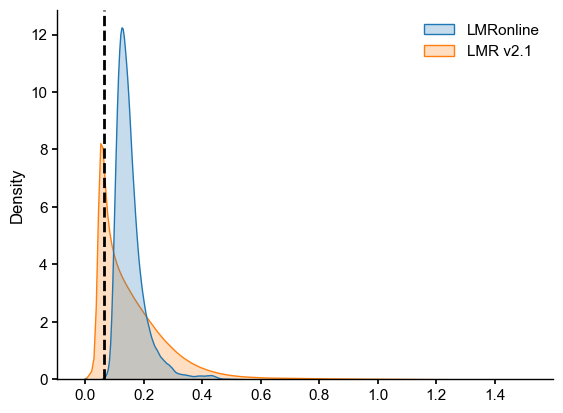

In [19]:
data = {'LMRonline': LMRon_intra_dist, 'LMR v2.1': LMRoff_intra_dist}
df = pd.DataFrame(data)
fig, ax  = plt.subplots()
sns.kdeplot(df, fill=True, ax=ax, common_norm=False)
#sns.histplot(df, ax=ax,stat="density", kde=True)
ax.axvline(x=LMR_on_off_plume_dist,color="black", linestyle="--",label='plume distance')

We see that the plume distance falls between the intra-ensemble distances. The `LMRonline` distances are clustured relatively tigthly around 0.2, and are entirely encompassed by the much wider range of distances found in LMR2.1. This would argue for the ensembles being considered compatible with each other. Let us make sure this is not an artifact of the lack of temporal varaibility in individual traces in the LMR 2.1 (offline) ensemble. Let's resample it according to a power law, as done in the `resampling.ipynb` notebook:

In [79]:
ens_off_pl = ens_off.random_paths(model='power-law',param=0.92,p=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1133.23it/s]


In [80]:
LMRoff_pl_intra_dist = ens_off_pl.distance()

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:34<00:00, 57788.55it/s]


In [81]:
LMR_on_off_pl_plume_dist = ens_o2000.plume_distance(ens_off_pl,max_dist=0.7)

Computing inter-ensemble distance: 100%|██████████| 2000/2000 [00:49<00:00, 40.22it/s]


In [82]:
print(LMR_on_off_pl_plume_dist)

0.12731631979474148


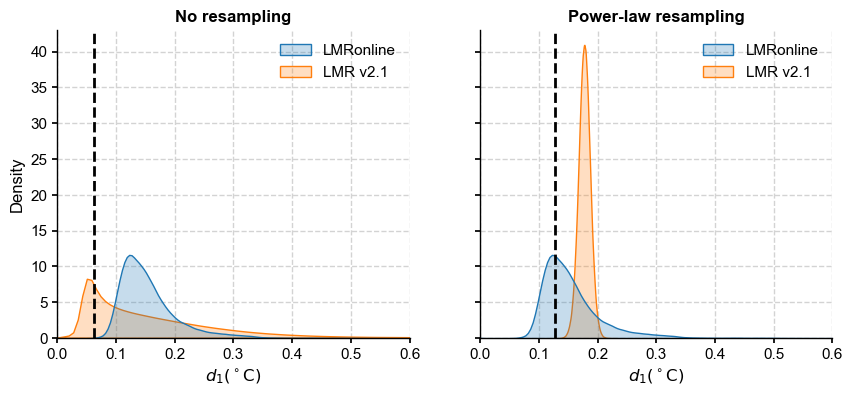

In [87]:
data = {'LMRonline': LMRon_intra_dist, 'LMR v2.1': LMRoff_pl_intra_dist}
df_pl = pd.DataFrame(data)
fig, axs  = plt.subplots(1,2,figsize=(10,4),sharey=True, sharex=True)
axs = axs.flatten()
axs[0].axvline(x=LMR_on_off_plume_dist,color="black", linestyle="--",label='plume distance')
sns.kdeplot(df, fill=True, ax=axs[0], common_norm=False)
axs[0].set_title('No resampling',weight='bold')
axs[0].set_xlim(0, 0.6)
axs[0].set_xlabel(r'$d_1 ({}^\circ \mathrm{C})$')
axs[1].axvline(x=LMR_on_off_pl_plume_dist,color="black", linestyle="--",label='plume distance')
sns.kdeplot(df_pl, fill=True, ax=axs[1], common_norm=False)
axs[1].set_title('Power-law resampling',weight='bold')
axs[1].set_xlabel(r'$d_1 ({}^\circ \mathrm{C})$')
fig.savefig('../figures/LMR_intra_ensemble_distances.pdf',dpi=200, bbox_inches='tight')

The blue distribution is common to both plots. We can see that resampling has a dramatic effect on the intra-ensemble distribution (orange), and on the plume distance (dashed line) as well. It is therefore important to pick a sensible temporal model when assessing such distances. 
Now the roles are reversed: LMR2.1 sits within LMRonline, and the plume distance appears typical of LMRonline intra-ensemble distances, coinciding nearly perfectly with the mode of its distribution. I would conclude that these two ensembles are mutually compatible.  

Plot this on its own (for AGU 2023 talk)

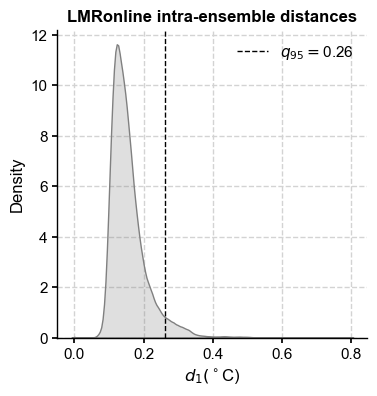

In [86]:
fig, ax  = plt.subplots(figsize=(4,4))
sns.kdeplot(df['LMRonline'], fill=True, ax=ax, color='gray')
#sns.histplot(LMRon_intra_dist, ax=ax, stat="density", kde=True, color='Silver')
LMRon_q95 = np.quantile(LMRon_intra_dist,0.95)
ax.axvline(x=LMRon_q95,color="black", linestyle="--",linewidth=1,label=rf'$q_{{95}}=${LMRon_q95:.2f}')
ax.set_title('LMRonline intra-ensemble distances',fontweight='bold')
ax.legend()
ax.set_xlabel(r'$d_1 ({}^\circ$C)')
fig.savefig('../figures/LMRonline_intra_dist.pdf',dpi=200, bbox_inches='tight')

### PMIP3 distances to LMRonline

In [20]:
ms_pmip.series_list[2]

{'label': 'FGOALS_gl'}


None
Time [yrs]
1000.0   -0.159104
1001.0   -0.498624
1002.0   -0.424599
1003.0   -0.261818
1004.0   -0.381586
            ...   
1994.0    0.292927
1995.0    0.341958
1996.0    0.121402
1997.0    0.229942
1998.0    0.345065
Name: GMST [°C], Length: 999, dtype: float64

In [45]:
common = [1000, 1998] # FGOALS is ruining it for everyone else.
pmip3_plume_dist = np.empty((2,len(ts_list)))
for i, ts in enumerate(ms_pmip.series_list):
    ts_lm = ts.slice(common)
    pmip3_plume_dist[0,i] = ens_on.slice(common).plume_distance(y=ts_lm.value, max_dist=1.5)
    pmip3_plume_dist[1,i] = ens_off.slice(common).plume_distance(y=ts_lm.value, max_dist=1.5)
    print(f'Model {ts.label} has distance {pmip3_plume_dist[0,i]} to LMRonline')
    print(f'Model {ts.label} has distance {pmip3_plume_dist[1,i]} to LMRv2.1')

Model bcc_csm1_1 has distance 0.41085444610034777 to LMRonline
Model bcc_csm1_1 has distance 0.43046251993620416 to LMRv2.1
Model CCSM4 has distance 0.49210526315789477 to LMRonline
Model CCSM4 has distance 0.5127978817299206 to LMRv2.1
Model FGOALS_gl has distance 0.2326785442363332 to LMRonline
Model FGOALS_gl has distance 0.2362778730703259 to LMRv2.1
Model FGOALS_s2 has distance 0.977866620314039 to LMRonline
Model FGOALS_s2 has distance 1.0034364261168385 to LMRv2.1
Model IPSL_CM5A_LR has distance 0.6359961555857078 to LMRonline
Model IPSL_CM5A_LR has distance 0.657354797979798 to LMRv2.1
Model MPI_ESM_P has distance 0.34887920298879205 to LMRonline
Model MPI_ESM_P has distance 0.3657543173672206 to LMRv2.1
Model CSIRO has distance 0.2902808573540281 to LMRonline
Model CSIRO has distance 0.30498533724340177 to LMRv2.1
Model HadCM3 has distance 0.2167681659207083 to LMRonline
Model HadCM3 has distance 0.21379145788594608 to LMRv2.1
Model CESM has distance 0.14846864365580945 to LMR

Export to a LaTeX table for the paper:

In [46]:
df = pd.DataFrame(pmip3_plume_dist,
                  index = ['LMRon','LMRoff'],
                  columns= dfn.columns[1:])
                       
print(df.to_latex(formatters={"name": str.upper}, float_format="%.2f"))  

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & bcc_csm1_1 & CCSM4 & FGOALS_gl & FGOALS_s2 & IPSL_CM5A_LR & MPI_ESM_P & CSIRO & HadCM3 & CESM & GISS \\
\midrule
LMRon & 0.41 & 0.49 & 0.23 & 0.98 & 0.64 & 0.35 & 0.29 & 0.22 & 0.15 & 0.29 \\
LMRoff & 0.43 & 0.51 & 0.24 & 1.00 & 0.66 & 0.37 & 0.30 & 0.21 & 0.13 & 0.31 \\
\bottomrule
\end{tabular}



Benchmarks:

In [47]:
LMRon_q95 = np.quantile(LMRon_intra_dist,0.95)
print(f'{LMRon_q95:.2f}')

0.27


In [48]:
LMRoff_q95 = np.quantile(LMRoff_pl_intra_dist,0.95)
print(f'{LMRoff_q95:.2f}')

0.19


### Illustrate tube around HadCM3

Text(0.5, 1.0, 'Finding HadCM3 neighbors in LMRonline')

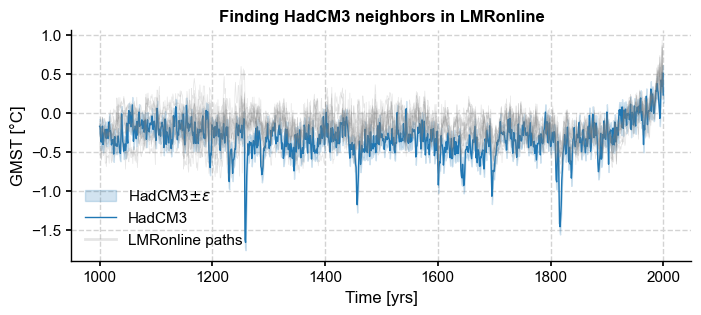

In [70]:
pens.set_style('journal_grid')
fig_a, ax = plt.subplots(1,1,figsize = (8,3))
eps=0.1
xlabel, ylabel = HadCM3.make_labels()
ax.fill_between(HadCM3.time, HadCM3.value-eps, HadCM3.value+eps, color='tab:blue', alpha=0.2,
                label=r'HadCM3$\pm \epsilon$')
HadCM3.plot(alpha=1, linewidth=1, color='tab:blue',linestyle='-',ax=ax)
ens_on.plot_traces(num_traces=10, alpha=0.2, ax=ax, color='gray',label='LMRonline paths')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('Finding HadCM3 neighbors in LMRonline',fontweight='bold')

In [71]:
fig_a.savefig('../figures/HadCM3_tube.pdf',dpi=200, bbox_inches='tight')